# Finetune pretrained Gluon model -- Not Hotdog!
This example demonstrates **how to finetune a squeezenet-1.1 that is pretrained on imagenet-12**, and train it to recognize **hotdogs**.

![hot dog](img/comic-hot-dog.png)

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function
import logging
logging.basicConfig(level=logging.INFO)
import os
import time
from collections import OrderedDict
import skimage.io as io

import mxnet as mx
from mxnet.test_utils import download
mx.random.seed(123)

## Settings

In [3]:
# Demo mode uses the validation dataset for training, which is smaller and faster to train.
demo = True
log_interval = 100
gpus = 0

# Options are imperative or hybrid. Use hybrid for better performance.
mode = 'hybrid'

# training hyperparameters
batch_size = 256
if demo:
    epochs = 5
    learning_rate = 0.02
    wd = 0.002
else:
    epochs = 40
    learning_rate = 0.05
    wd = 0.002

# the class weight for hotdog class to help the imbalance problem.
positive_class_weight = 5

## Dataset
We treat this task as a binary classification problem, with 1 for hotdog class, and 0 for not hotdog class. The dataset on which to finetune the model, 'not hotdog', consists of 18,141 sample images, 2091 of which are hotdogs.
Because the dataset is imbalanced (e.g. hotdog class is only 1% in mscoco dataset), sampling interesting negative samples can help improve the performance of learning. Thus, in the negative class in the our dataset, two-thirds are images from food categories (e.g. pizza) other than hotdogs, and 30% are images from all other categories.

### Files
Our dataset is prepared in the format of MXRecord using [im2rec](http://mxnet.io/how_to/recordio.html?highlight=im2rec) tool.
- not_hotdog_train.rec 641M (1882 positive, 10000 intersting negative, and 5000 random negative)
- not_hotdog_validation.rec 49M (209 positive, 700 intersting negative, and 350 random negative)

In [4]:
dataset_files = {'train': ('not_hotdog_train-e6ef27b4.rec', '0aad7e1f16f5fb109b719a414a867bbee6ef27b4'),
                 'validation': ('not_hotdog_validation-c0201740.rec', '723ae5f8a433ed2e2bf729baec6b878ac0201740')}

We're using the smaller validation set in training for demo purpose. For those who are interested in training on the full set, set 'demo' to False in the settings at the beginning.

Now we are ready to download and verify the dataset.

In [5]:
if demo:
    training_dataset, training_data_hash = dataset_files['validation']
else:
    training_dataset, training_data_hash = dataset_files['train']

validation_dataset, validation_data_hash = dataset_files['validation']

def verified(file_path, sha1hash):
    import hashlib
    sha1 = hashlib.sha1()
    with open(file_path, 'rb') as f:
        while True:
            data = f.read(1048576)
            if not data:
                break
            sha1.update(data)
    matched = sha1.hexdigest() == sha1hash
    if not matched:
        logging.warn('Found hash mismatch in file {}, possibly due to incomplete download.'
                     .format(file_path))
    return matched

url_format = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/{}'
if not os.path.exists(training_dataset) or not verified(training_dataset, training_data_hash):
    logging.info('Downloading training dataset.')
    download(url_format.format(training_dataset),
             overwrite=True)
if not os.path.exists(validation_dataset) or not verified(validation_dataset, validation_data_hash):
    logging.info('Downloading validation dataset.')
    download(url_format.format(validation_dataset),
             overwrite=True)

INFO:root:Downloading training dataset.
INFO:root:downloaded https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/not_hotdog_validation-c0201740.rec into not_hotdog_validation-c0201740.rec successfully


### Iterators

The record files can be read using [mx.io.ImageRecordIter](http://mxnet.io/api/python/io.html#mxnet.io.ImageRecordIter)

In [6]:
# load dataset
train_iter = mx.io.ImageRecordIter(path_imgrec=training_dataset,
                                   min_img_size=256,
                                   data_shape=(3, 224, 224),
                                   rand_crop=True,
                                   shuffle=True,
                                   batch_size=batch_size,
                                   max_random_scale=1.5,
                                   min_random_scale=0.75,
                                   rand_mirror=True)
val_iter = mx.io.ImageRecordIter(path_imgrec=validation_dataset,
                                 min_img_size=256,
                                 data_shape=(3, 224, 224),
                                 batch_size=batch_size)

## Model

The model we are finetuning is [SqueezeNet](https://arxiv.org/abs/1602.07360). Gluon module offers squeezenet v1.0 and v1.1 that are pretrained on ImageNet.

### Pretrained Gluon model

In [7]:
from mxnet.gluon import nn
from mxnet.gluon.model_zoo import vision as models

# get pretrained squeezenet
net = models.squeezenet1_1(pretrained=True, prefix='deep_dog_')
# hot dog happens to be a class in imagenet.
# we can reuse the weight for that class for better performance
# here's the index for that class for later use
imagenet_hotdog_index = 713

Model file is not found. Downloading.


INFO:root:downloaded https://apache-mxnet.s3.amazonaws.com/gluon/models/squeezenet1.1-33ba0f93.zip into /Users/astonz/.mxnet/models/squeezenet1.1-33ba0f93.zip successfully


### DeepDog net
We can now use the feature extractor part from the pretrained squeezenet to build our own network. 

In [8]:
deep_dog_net = models.squeezenet1_1(prefix='deep_dog_', classes=2)
deep_dog_net.collect_params().initialize()
deep_dog_net._children[0] = net.features
print(deep_dog_net)

SqueezeNet(
  (features): HybridSequential(
    (0): Conv2D(64, kernel_size=(3, 3), stride=(2, 2))
    (1): Activation(relu)
    (2): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=True)
    (3): HybridSequential(
      (0): HybridSequential(
        (0): Conv2D(16, kernel_size=(1, 1), stride=(1, 1))
        (1): Activation(relu)
      )
      (1): HybridConcurrent(
        (0): HybridSequential(
          (0): Conv2D(64, kernel_size=(1, 1), stride=(1, 1))
          (1): Activation(relu)
        )
        (1): HybridSequential(
          (0): Conv2D(64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): Activation(relu)
        )
      )
    )
    (4): HybridSequential(
      (0): HybridSequential(
        (0): Conv2D(16, kernel_size=(1, 1), stride=(1, 1))
        (1): Activation(relu)
      )
      (1): HybridConcurrent(
        (0): HybridSequential(
          (0): Conv2D(64, kernel_size=(1, 1), stride=(1, 1))
          (1): Activation(relu)
        )


The network can already be used for prediction. However, since it hasn't been finetuned yet, the network performance could be bad.

In [9]:
from skimage.color import rgba2rgb

def classify_hotdog(net, url):
    I = io.imread(url)
    if I.shape[2] == 4:
        I = rgba2rgb(I)
    image = mx.nd.array(I).astype(np.uint8)
    plt.subplot(1, 2, 1)
    plt.imshow(image.asnumpy())
    image = mx.image.resize_short(image, 256)
    image, _ = mx.image.center_crop(image, (224, 224))
    plt.subplot(1, 2, 2)
    plt.imshow(image.asnumpy())
    image = mx.image.color_normalize(image.astype(np.float32)/255,
                                     mean=mx.nd.array([0.485, 0.456, 0.406]),
                                     std=mx.nd.array([0.229, 0.224, 0.225]))
    image = mx.nd.transpose(image.astype('float32'), (2,1,0))
    image = mx.nd.expand_dims(image, axis=0)
    out = mx.nd.SoftmaxActivation(net(image))
    print('Probabilities are: '+str(out[0].asnumpy()))
    result = np.argmax(out.asnumpy())
    outstring = ['Not hotdog!', 'Hotdog!']
    print(outstring[result])

Probabilities are: [ 0.5  0.5]
Not hotdog!


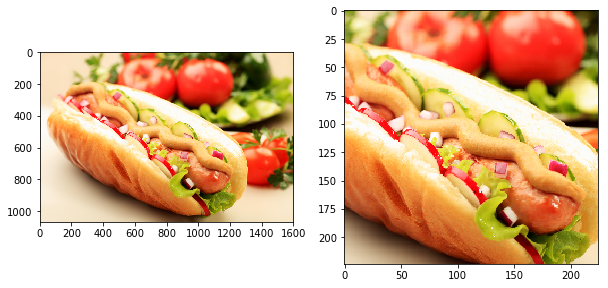

In [10]:
classify_hotdog(deep_dog_net, 'img/real_hotdog.jpg')

### Reuse class weights
As mentioned earlier, in addition to the feature extractor, we can reuse the class weights for hot dog from the pretrained model, since hot dog was already a class in the imagenet. To do that, we need to get the weight from the classifier layers of the pretrained model, find the right slice, and put it into our two-class classifier.

In [11]:
# let's examine the classifier and find the last conv layer
print(net.classifier)

HybridSequential(
  (0): Dropout(p = 0.5)
  (1): Conv2D(1000, kernel_size=(1, 1), stride=(1, 1))
  (2): Activation(relu)
  (3): AvgPool2D(size=(13, 13), stride=(13, 13), padding=(0, 0), ceil_mode=False)
  (4): Flatten
)


In [12]:
# the last conv layer is the second layer
pretrained_conv_params = net.classifier[1].params

# weights can then be found from the above parameter dict
pretrained_weight_param = pretrained_conv_params.get('weight')
pretrained_bias_param = pretrained_conv_params.get('bias')

# next, we locate the right slice that we're interested in.
hotdog_w = mx.nd.split(pretrained_weight_param.data().as_in_context(mx.cpu()),
                       1000, axis=0)[imagenet_hotdog_index]
hotdog_b = mx.nd.split(pretrained_bias_param.data().as_in_context(mx.cpu()),
                       1000, axis=0)[imagenet_hotdog_index]

# our classifier is for two classes. here, we reuse the hotdog class weight,
# and randomly initialize the 'not hotdog' class.
new_classifier_w = mx.nd.concat(mx.nd.random_normal(shape=hotdog_w.shape, scale=0.02),
                                hotdog_w,
                                dim=0)
new_classifier_b = mx.nd.concat(mx.nd.random_normal(shape=hotdog_b.shape, scale=0.02),
                                hotdog_b,
                                dim=0)

# finally, we initialize the parameter buffers and set the values.
final_conv_layer_params = deep_dog_net.classifier._children[1].params
final_conv_layer_params.get('weight').set_data(new_classifier_w)
final_conv_layer_params.get('bias').set_data(new_classifier_b)

## Evaluation
Our task is a binary classification problem with imbalanced classes. We should monitor both the accuracy and F1 score

In [13]:
# return metrics string representation
def metric_str(names, accs):
    return ', '.join(['%s=%f'%(name, acc) for name, acc in zip(names, accs)])
metric = mx.metric.create(['acc', 'f1'])

The following snippet performs inferences on evaluation dataset, and updates the metrics. Once the evaluation dataste iterator is exhausted, it returns the metrics results.

In [14]:
import mxnet.gluon as gluon
from mxnet.image import color_normalize

def evaluate(net, data_iter, ctx):
    data_iter.reset()
    for batch in data_iter:
        data = color_normalize(batch.data[0]/255,
                               mean=mx.nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1)),
                               std=mx.nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1)))
        data = gluon.utils.split_and_load(data, ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
        outputs = []
        for x in data:
            outputs.append(net(x))
        metric.update(label, outputs)
    out = metric.get()
    metric.reset()
    return out

## Training

We can now use autograd for training.

In [15]:
import mxnet.autograd as autograd

def train(net, train_iter, val_iter, epochs, ctx):
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate, 'wd': wd})
    loss = gluon.loss.SoftmaxCrossEntropyLoss()

    best_f1 = 0
    val_names, val_accs = evaluate(net, val_iter, ctx)
    logging.info('[Initial] validation: %s'%(metric_str(val_names, val_accs)))
    for epoch in range(epochs):
        tic = time.time()
        train_iter.reset()
        btic = time.time()
        for i, batch in enumerate(train_iter):
            # the model zoo models expect normalized images
            data = color_normalize(batch.data[0]/255,
                                   mean=mx.nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1)),
                                   std=mx.nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1)))
            data = gluon.utils.split_and_load(data, ctx_list=ctx, batch_axis=0)
            label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
            outputs = []
            Ls = []
            with autograd.record():
                for x, y in zip(data, label):
                    z = net(x)
                    # rescale the loss based on class to counter the imbalance problem
                    L = loss(z, y) * (1+y*positive_class_weight)/positive_class_weight
                    # store the loss and do backward after we have done forward
                    # on all GPUs for better speed on multiple GPUs.
                    Ls.append(L)
                    outputs.append(z)
                for L in Ls:
                    L.backward()
            trainer.step(batch.data[0].shape[0])
            metric.update(label, outputs)
            if log_interval and not (i+1)%log_interval:
                names, accs = metric.get()
                logging.info('[Epoch %d Batch %d] speed: %f samples/s, training: %s'%(
                               epoch, i, batch_size/(time.time()-btic), metric_str(names, accs)))
            btic = time.time()

        names, accs = metric.get()
        metric.reset()
        logging.info('[Epoch %d] training: %s'%(epoch, metric_str(names, accs)))
        logging.info('[Epoch %d] time cost: %f'%(epoch, time.time()-tic))
        val_names, val_accs = evaluate(net, val_iter, ctx)
        logging.info('[Epoch %d] validation: %s'%(epoch, metric_str(val_names, val_accs)))

        if val_accs[1] > best_f1:
            best_f1 = val_accs[1]
            logging.info('Best validation f1 found. Checkpointing...')
            net.save_params('deep-dog-%d.params'%(epoch))

if mode == 'hybrid':
    deep_dog_net.hybridize()
if epochs > 0:
    contexts = [mx.gpu(i) for i in range(gpus)] if gpus > 0 else [mx.cpu()]
    deep_dog_net.collect_params().reset_ctx(contexts)
    train(deep_dog_net, train_iter, val_iter, epochs, contexts)

INFO:root:[Initial] validation: accuracy=0.193750, f1=0.287817
INFO:root:[Epoch 0] training: accuracy=0.426563, f1=0.250905
INFO:root:[Epoch 0] time cost: 116.254453
INFO:root:[Epoch 0] validation: accuracy=0.587500, f1=0.383191
INFO:root:Best validation f1 found. Checkpointing...
INFO:root:[Epoch 1] training: accuracy=0.514062, f1=0.388243
INFO:root:[Epoch 1] time cost: 115.413273
INFO:root:[Epoch 1] validation: accuracy=0.642188, f1=0.433638
INFO:root:Best validation f1 found. Checkpointing...
INFO:root:[Epoch 2] training: accuracy=0.568750, f1=0.415038
INFO:root:[Epoch 2] time cost: 124.882045
INFO:root:[Epoch 2] validation: accuracy=0.687500, f1=0.453106
INFO:root:Best validation f1 found. Checkpointing...
INFO:root:[Epoch 3] training: accuracy=0.603125, f1=0.437317
INFO:root:[Epoch 3] time cost: 123.522857
INFO:root:[Epoch 3] validation: accuracy=0.678125, f1=0.483496
INFO:root:Best validation f1 found. Checkpointing...
INFO:root:[Epoch 4] training: accuracy=0.654687, f1=0.476220


## Try it out!
Once our model is trained, we can either use the `deep_dog_net` model in the notebook kernel, or load it from the best checkpoint.

In [16]:
# Uncomment below line and replace the file name with the last checkpoint.
# deep_dog_net.load_params('deep-dog-4.params', mx.cpu())
#
# Alternatively, you can uncomment the following lines to get the model that we finetuned,
# with validation F1 score of 0.74.
download('https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/models/deep-dog-5a342a6f.params',
         overwrite=True)
deep_dog_net.load_params('deep-dog-5a342a6f.params', mx.cpu())

INFO:root:downloaded https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/models/deep-dog-5a342a6f.params into deep-dog-5a342a6f.params successfully


Probabilities are: [ 0.19303347  0.80696648]
Hotdog!


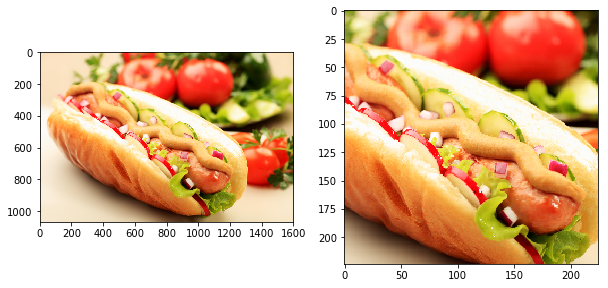

In [17]:
classify_hotdog(deep_dog_net, 'img/real_hotdog.jpg')

Probabilities are: [ 0.92225069  0.07774929]
Not hotdog!


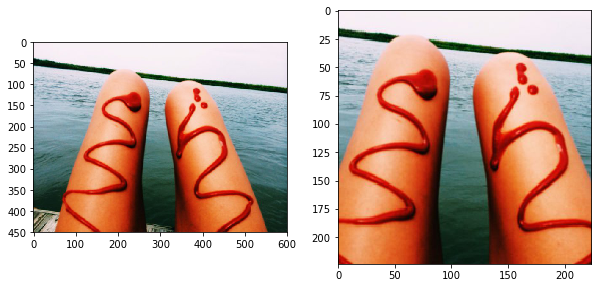

In [18]:
classify_hotdog(deep_dog_net, 'img/leg_hotdog.jpg')

Probabilities are: [ 0.99648535  0.00351469]
Not hotdog!


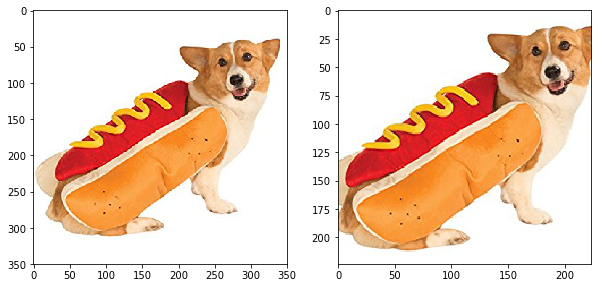

In [19]:
classify_hotdog(deep_dog_net, 'img/dog_hotdog.jpg')